In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [52]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        
        # Max pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Output layer with 2 classes
        
        # Dropout layer
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        
        # Convolutional layers with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the feature maps
        x = x.view(-1, 16 * 8 * 8)
        
        # Fully connected layers with ReLU activation and dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        
        # Output layer with softmax activation
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

# Create an instance of the CNN model
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [53]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader

In [54]:
# Define custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root_dir, transform=transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

# Define transformation to be applied to images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor()          # Convert images to PyTorch tensors
])
main_dir = 'data/TrainingValidation'
sunrise_dir = 'data/CompareToSunrise'
# Create custom dataset instances for training and validation
train_dataset = CustomDataset(root_dir=sunrise_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

# Create DataLoader instances for training and validation
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)


In [55]:
from tqdm import tqdm

In [57]:
# 1. Load model
model_to_load = "models/V2_1.pth"  # Set to None if you want to train a new model from scratch
model = CNN() 
if model_to_load is not None:
    model.load_state_dict(torch.load(model_to_load))
    print("Model loaded successfully")
else:
    print("Training a new model")

Model loaded successfully


In [59]:
# Lists to store training and validation errors
train_errors = []
val_errors = []

# Step 2: Define Loss Function
criterion = nn.CrossEntropyLoss()

# Step 3: Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

last_input = []

SAVE_NAME = 'models/V2_2'

# Step 4: Iterate Over Training Data
num_epochs = 10
for epoch in range(num_epochs):
    
    model.train()
    # Assuming train_loader is your DataLoader containing training data
    for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        # Step 5: Forward Pass
        outputs = model(inputs)
        # Step 6: Compute Loss
        loss = criterion(outputs, targets)
        
        # Step 7: Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # Step 8: Update Parameters
        optimizer.step()
    
    train_errors.append(loss.item())
    
    # evaluate the model
    model.eval()
    with torch.no_grad():
        curr_loss = 0
        # Assuming val_loader is your DataLoader containing validation data
        for inputs, targets in tqdm(valid_loader, desc="testing data"):
            outputs = model(inputs.view(inputs.shape[0], 3, 64, 64))
            loss = criterion(outputs, targets)
            curr_loss += loss.item()
        val_errors.append(curr_loss / len(valid_loader))
        
    if len(val_errors) > 1:
        if min(val_errors) == val_errors[-1]:
            torch.save(model.state_dict(), f'{SAVE_NAME}.pth')
            
    # Optional: Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss_train: {train_errors[-1]:.4f}, Loss_val: {val_errors[-1]:.4f}')
    
print('Training finished.')


testing data: 100%|██████████| 12/12 [00:00<00:00, 17.19it/s]


Epoch [1/10], Loss_train: 0.6235, Loss_val: 0.6048


testing data: 100%|██████████| 12/12 [00:00<00:00, 16.77it/s]


Epoch [2/10], Loss_train: 0.5445, Loss_val: 0.5855


testing data: 100%|██████████| 12/12 [00:00<00:00, 16.66it/s]


Epoch [3/10], Loss_train: 0.4675, Loss_val: 0.5646


testing data: 100%|██████████| 12/12 [00:00<00:00, 16.99it/s]


Epoch [4/10], Loss_train: 0.4291, Loss_val: 0.5587


testing data: 100%|██████████| 12/12 [00:01<00:00,  9.46it/s]


Epoch [5/10], Loss_train: 0.5959, Loss_val: 0.5435


testing data: 100%|██████████| 12/12 [00:00<00:00, 17.01it/s]


Epoch [6/10], Loss_train: 0.3707, Loss_val: 0.5311


testing data: 100%|██████████| 12/12 [00:00<00:00, 17.31it/s]


Epoch [7/10], Loss_train: 0.6062, Loss_val: 0.5205


testing data: 100%|██████████| 12/12 [00:00<00:00, 16.75it/s]


Epoch [8/10], Loss_train: 0.4616, Loss_val: 0.5133


testing data: 100%|██████████| 12/12 [00:00<00:00, 18.52it/s]


Epoch [9/10], Loss_train: 0.5347, Loss_val: 0.5090


testing data: 100%|██████████| 12/12 [00:00<00:00, 18.06it/s]

Epoch [10/10], Loss_train: 0.5545, Loss_val: 0.5263
Training finished.


In [60]:
#Nb True | NB itterations
ans = [0, 0]
for inputs, targets in tqdm(valid_loader):
    ans[0] += sum(model(inputs.view(inputs.shape[0], 3, 64, 64)).argmax(dim=1) == targets)
    ans[1] += len(targets)
print(f"{ans[0]} True over {ans[1]} itterations (= {ans[0]/ans[1]*100}%)")

100%|██████████| 12/12 [00:00<00:00, 17.05it/s]

278 True over 356 itterations (= 78.08988952636719%)


Model loaded successfully
Prediction: Fire


[0]

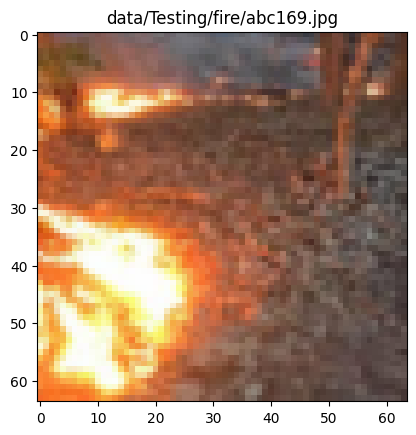

In [61]:
from PIL import Image
from matplotlib import pyplot as plt

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor()          # Convert images to PyTorch tensors
])

model = CNN()
MODEL_PATH = "models/V2_1.pth"
if MODEL_PATH is not None:
    model.load_state_dict(torch.load(MODEL_PATH))
    print("Model loaded successfully")
else:
    print("Training a new model")
    
def try_image(image_path, transformation, model, *, show=True):
    
    #Image has to be transformed to a 64x64 image
    img = Image.open(image_path)
    img = transform(img)
    
    output = [model(img.unsqueeze(0)).argmax(dim=1).item()]
    if show:
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"{image_path}")
        print("Prediction:", ["Fire", "No Fire"][model(img.unsqueeze(0)).argmax(dim=1).item()])
    return output

In [ ]:
try_image('data/Testing/fire/abc169.jpg', transform, model)

Prediction: Fire


[0]

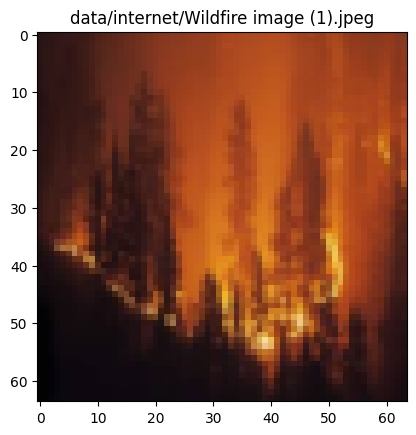

In [42]:
#Lets try with an image from the internet 

try_image('data/internet/Wildfire image (1).jpeg', transform, model)

Prediction: No Fire


[1]

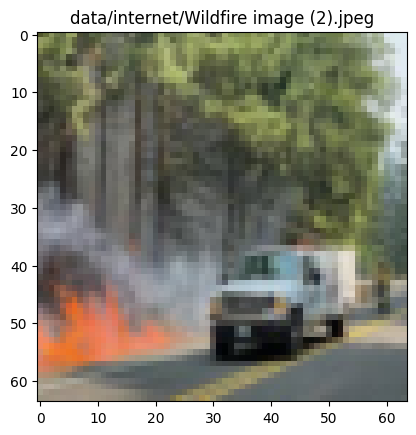

In [44]:
image_path = 'data/internet/Wildfire image (2).jpeg'

try_image(image_path, transform, model)

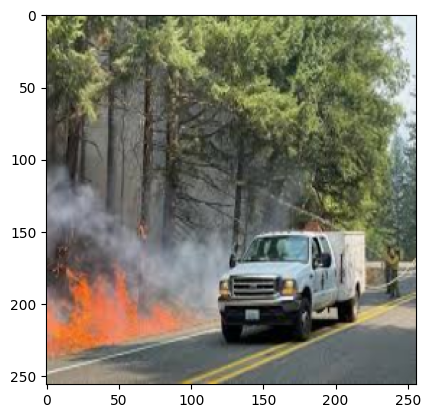

In [48]:
from PIL import Image
from matplotlib import pyplot as plt

transform2 = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 64x64
    transforms.ToTensor()          # Convert images to PyTorch tensors
])

img = Image.open(image_path)
img = transform2(img)
plt.imshow(img.permute(1, 2, 0))


Prediction: No Fire


[1]

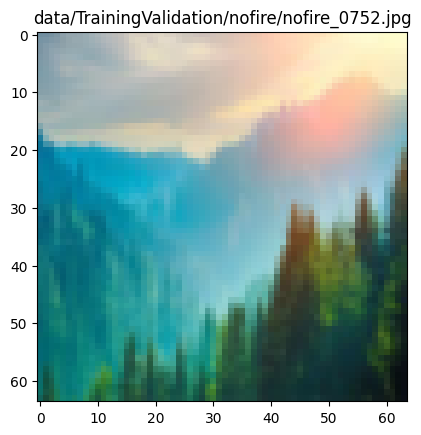

In [49]:
image_path = 'data/TrainingValidation/nofire/nofire_0752.jpg'

try_image(image_path, transform, model)

Prediction: Fire


[0]

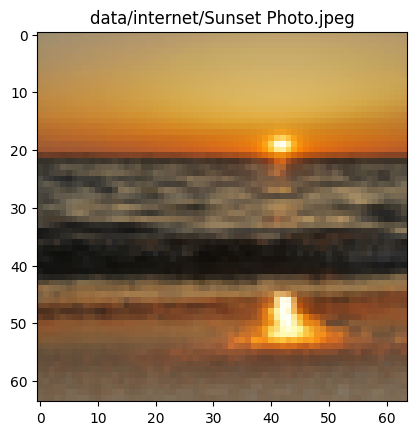

In [62]:
image_path = 'data/internet/Sunset Photo.jpeg'

try_image(image_path, transform, model)

In [63]:

main_dir = 'data/TrainingValidation'
sunrise_dir = 'data/CompareToSunrise'
testDir = 'data/Testing'
# Create custom dataset instances for training and validation
test_dataset = CustomDataset(root_dir=testDir, transform=transform)

# Create DataLoader instances for training and validation
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [64]:
ans = [0, 0]
for inputs, targets in tqdm(test_loader):
    ans[0] += sum(model(inputs.view(inputs.shape[0], 3, 64, 64)).argmax(dim=1) == targets)
    ans[1] += len(targets)
print(f"{ans[0]} True over {ans[1]} itterations (= {ans[0]/ans[1]*100}%)")

100%|██████████| 3/3 [00:48<00:00, 16.21s/it]

62 True over 68 itterations (= 91.17646789550781%)


Thaks to our first training with the normal dataset and then the other training with the sunrise vs fire dataset, the model is more resistant but with a little bit less accuracy.

1st training on TrainingValidation:
    - accuracy: 95% but can't distinguish sunrises from fire

2nd training on CompareToSunrise
    - accuracy: 91% but can distinguish sunrises from fire